In [ ]:
#  "sustainability" and "data" , Pakistan

In [1]:
import math

import re
import os

In [2]:
document_titles = {}

In [3]:
def add_documents_from_directory(directory_path):
    """Add all text files from a directory to the documents list."""
    documents = []  # List to hold the contents of documents
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".txt"):  # Process only .txt files
            file_path = os.path.join(directory_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                title = os.path.splitext(os.path.basename(file_path))[0]  # Extract title from file name
                content = file.read()
                doc_id = hash(file_path)  # Use a hash of the file path as a unique ID
                document_titles[doc_id] = title  # Store the title with doc_id
                documents.append(content)
    return documents

# documents list with the documents loaded from a directory
directory_path = "./Documents_02/test"
documents = add_documents_from_directory(directory_path)

In [4]:
def preprocess(text):
     # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)  # Retain only words and spaces

    # Lowercase, split into words, and remove stopwords
    words = text.lower().split()
    return words

# Tokenized documents
tokenized_docs = [preprocess(doc) for doc in documents]

tokenized_docs

[['it', 'is', 'going', 'to', 'rain', 'today'],
 ['today', 'i', 'am', 'not', 'going', 'outside'],
 ['i', 'am', 'going', 'to', 'watch', 'the', 'season', 'premiere']]

In [5]:
from collections import Counter

# Step 3: Calculate term frequency (TF)
def compute_tf(doc_tokens):
    tf = Counter(doc_tokens)
    for term in tf:
        tf[term] /= len(doc_tokens)
    return tf
for doc in tokenized_docs:
    print(compute_tf(doc))


Counter({'it': 0.16666666666666666, 'is': 0.16666666666666666, 'going': 0.16666666666666666, 'to': 0.16666666666666666, 'rain': 0.16666666666666666, 'today': 0.16666666666666666})
Counter({'today': 0.16666666666666666, 'i': 0.16666666666666666, 'am': 0.16666666666666666, 'not': 0.16666666666666666, 'going': 0.16666666666666666, 'outside': 0.16666666666666666})
Counter({'i': 0.125, 'am': 0.125, 'going': 0.125, 'to': 0.125, 'watch': 0.125, 'the': 0.125, 'season': 0.125, 'premiere': 0.125})


In [6]:
# Step 4: Calculate inverse document frequency (IDF)
def compute_idf(tokenized_docs):
    num_docs = len(tokenized_docs)
    idf = {}
    all_terms = set(term for doc in tokenized_docs for term in doc)
    for term in all_terms:
        doc_count = sum(1 for doc in tokenized_docs if term in doc)
        idf[term] = math.log(num_docs / doc_count)
        # idf[term] = math.log(num_docs / (1 + doc_count)) + 1
    return idf

idfs = compute_idf(tokenized_docs)
idfs

{'rain': 1.0986122886681098,
 'am': 0.4054651081081644,
 'the': 1.0986122886681098,
 'is': 1.0986122886681098,
 'i': 0.4054651081081644,
 'premiere': 1.0986122886681098,
 'to': 0.4054651081081644,
 'today': 0.4054651081081644,
 'season': 1.0986122886681098,
 'watch': 1.0986122886681098,
 'going': 0.0,
 'outside': 1.0986122886681098,
 'it': 1.0986122886681098,
 'not': 1.0986122886681098}

In [7]:
# Step 5: Compute TF-IDF for each document
def compute_tfidf(tf, idf):
    tfidf = {}
    for term, tf_value in tf.items():
        tfidf[term] = tf_value * idf.get(term, 0)
    return tfidf

# Compute IDF
tfidf_docs = [compute_tfidf(compute_tf(doc), idfs) for doc in tokenized_docs]
tfidf_docs

[{'it': 0.1831020481113516,
  'is': 0.1831020481113516,
  'going': 0.0,
  'to': 0.06757751801802739,
  'rain': 0.1831020481113516,
  'today': 0.06757751801802739},
 {'today': 0.06757751801802739,
  'i': 0.06757751801802739,
  'am': 0.06757751801802739,
  'not': 0.1831020481113516,
  'going': 0.0,
  'outside': 0.1831020481113516},
 {'i': 0.05068313851352055,
  'am': 0.05068313851352055,
  'going': 0.0,
  'to': 0.05068313851352055,
  'watch': 0.13732653608351372,
  'the': 0.13732653608351372,
  'season': 0.13732653608351372,
  'premiere': 0.13732653608351372}]

In [10]:
# Function to preprocess the query
def preprocess_query(query):
    return preprocess(query)  # Assuming 'preprocess' is defined elsewhere

# Function to compute TF-IDF for the query
def compute_query_tfidf(query_tokens, idfs):
    query_tf = compute_tf(query_tokens)  # Assuming 'compute_tf' is defined
    query_tfidf = compute_tfidf(query_tf, idfs)  # Assuming 'compute_tfidf' is defined
    return query_tfidf

# Function to calculate cosine similarity between query and a document
def compute_cosine_similarity(query_tfidf, doc_tfidf):
    dot_product = sum(query_tfidf.get(term, 0) * doc_tfidf.get(term, 0) for term in query_tfidf)
    query_norm = math.sqrt(sum(value ** 2 for value in query_tfidf.values()))
    doc_norm = math.sqrt(sum(value ** 2 for value in doc_tfidf.values()))
    return dot_product / (query_norm * doc_norm) if query_norm and doc_norm else 0

# Function to rank documents based on cosine similarity
def rank_documents(query, tfidf_docs, idfs):
    query_tokens = preprocess_query(query)
    query_tfidf = compute_query_tfidf(query_tokens, idfs)
    
    # Compute cosine similarity for all documents
    rankings = []
    for i, doc_tfidf in enumerate(tfidf_docs):
        similarity = compute_cosine_similarity(query_tfidf, doc_tfidf)
        rankings.append((i, similarity))
    
    # Sort by similarity score in descending order
    rankings.sort(key=lambda x: x[1], reverse=True)
    return rankings


In [11]:
etried = False
query = "it is rain"

rankings = rank_documents(query, tfidf_docs, idfs)
for rank, (doc_index, score) in enumerate(rankings, start=1):
    if score > 0:
        retried = True
        # Retrieve the document title using the doc_id (using the index in the rankings list)
        doc_id = list(document_titles.keys())[doc_index]
        document_title = document_titles[doc_id]
        print(f"{rank}. {document_title} (Score: {score :.4f}) & (Relevency: {score * 100:.2f}%)")

if not retried:
    print("\nSorry, no relevant documents found for your query. Please try again with different terms.")
# Run the CLI

1. Document1 (Score: 0.9575) & (Relevency: 95.75%)


# Step 10: Bonus (Optional)

### Simple text pre-processing

- Usually for unsupervised `word2vec` learning, we don't really need much text preprocessing.
- So we keep our preprocessing to the minimum.
    - Remove only symbols/punctuations, as well as redundant whitespaces.
    - Perform word tokenization, which would also determine the base units for embeddings learning.


In [7]:
import os
def add_documents_from_directory(directory_path):
    """Add all text files from a directory to the documents list."""
    documents = []  # List to hold the contents of documents
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".txt"):  # Process only .txt files
            file_path = os.path.join(directory_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                documents.append(content)
    return documents

# documents list with the documents loaded from a directory
directory_path = "./Documents_02"
documents = add_documents_from_directory(directory_path)

In [8]:
import nltk
import re
wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')
def preprocess_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    doc = ' '.join(tokens)
    return doc

corpus_norm = [preprocess_document(text) for text in documents]
corpus_tokens = [preprocess_document(text).split(' ') for text in documents]

In [9]:
print(corpus_norm)
print(corpus_tokens)

['artificial intelligence ai is transforming industries by enabling automation and decisionmaking machine learning algorithms analyze data to identify patterns making them valuable in healthcare finance and technology ai tools like chatbots and recommendation systems improve user experiences key terms include neural networks data and automation', 'environmental conservation efforts focus on preserving ecosystems and biodiversity strategies include reforestation reducing carbon emissions and protecting endangered species global organizations like the wwf and greenpeace advocate for sustainable practices terms like climate change pollution and sustainability are central to this topic', 'in pakistan different types of goods and services are available private goods are offered by private companies or individuals and require payment from people to access them on the other hand public goods and services are provided by the government to benefit the citizens of the country these include essen

### Training Embeddings Using word2vec

- The expected inputs of `gensim.model.word2vec` is token-based corpus object.

In [10]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 10
window_context = 5
min_word_count = 1

w2v_model = word2vec.Word2Vec(
    corpus_tokens,
    vector_size=feature_size,  # Word embeddings dimensionality
    window=window_context,    # Context window size
    min_count=min_word_count, # Minimum word count
    sg=1,                     # `1` for skip-gram; otherwise CBOW.
    seed = 123,               # random seed
    workers=1,                # number of cores to use
    negative = 5,             # how many negative samples should be drawn
    cbow_mean = 1,            # whether to use the average of context word embeddings or sum(concat)
    epochs=10000,               # number of epochs for the entire corpus
    batch_words=10000,        # batch size
)

### Visualizing Word Embeddings

- Embeddings represent words in multidimensional space.
- We can inspect the quality of embeddings using dimensional reduction and visualize words in a 2D plot.

c:\Users\my658\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


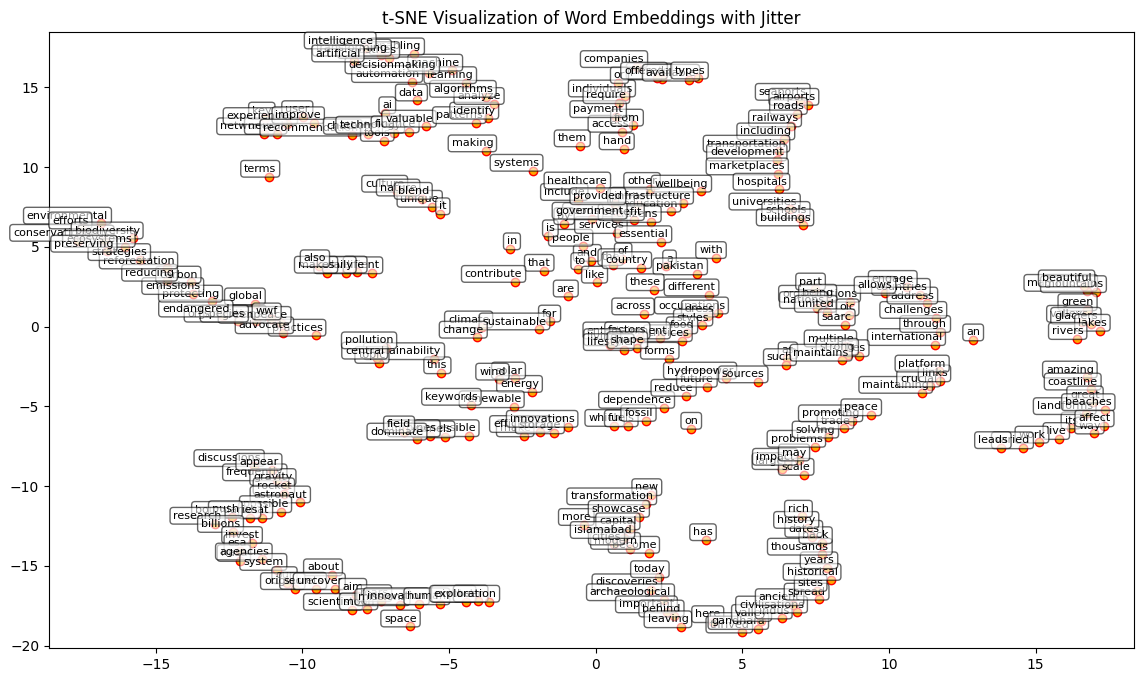

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

words = w2v_model.wv.index_to_key  # Get the word forms of the vocabulary
wvs = w2v_model.wv[words]  # Get embeddings of all word forms

# Apply TSNE with higher perplexity for more spread out clusters
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=30)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

# Add random jitter to prevent overlapping points
jitter_strength = 0.05
T_jittered = T + np.random.normal(0, jitter_strength, T.shape)

# Plotting
plt.figure(figsize=(14, 8))
plt.scatter(T_jittered[:, 0], T_jittered[:, 1], c='orange', edgecolors='r')

# Add annotations for each point with some offset
for label, x, y in zip(labels, T_jittered[:, 0], T_jittered[:, 1]):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),  # Offset position of the label
                 textcoords='offset points',
                 ha='right',  # Horizontal alignment of the label
                 va='bottom',  # Vertical alignment of the label
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.6),  # Add background to text
                 fontsize=8)  # Reduce font size for readability

# Zoom into the relevant region (optional, depending on your data distribution)
plt.xlim(min(T_jittered[:, 0]) - 1, max(T_jittered[:, 0]) + 1)
plt.ylim(min(T_jittered[:, 1]) - 1, max(T_jittered[:, 1]) + 1)

plt.title('t-SNE Visualization of Word Embeddings with Jitter')
plt.show()
